In [9]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

input_path = "./Submission/data_modified/"
savepath = "./Submission/gamma_data_modified/"

In [2]:
gt = Image.open('./Data/clear/26.JPG')
pred = Image.open("./Submission/data_modified/26.png")

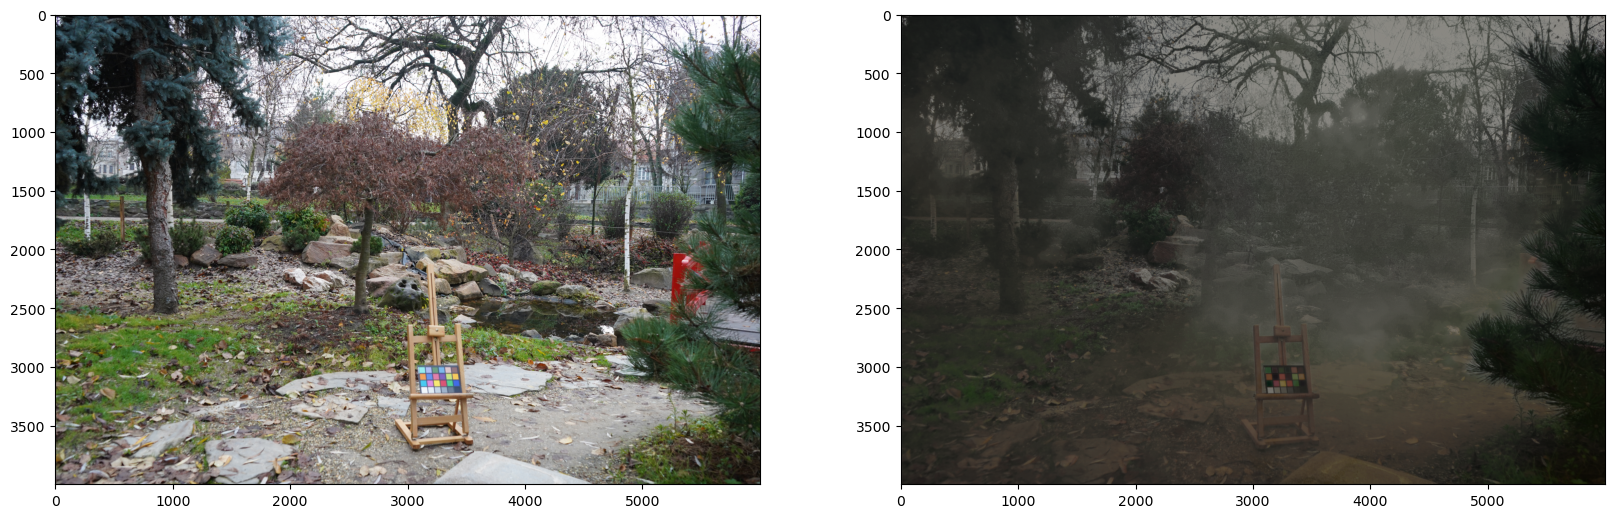

In [3]:
gt = np.array(gt)
pred = np.array(pred)[:,:,:3]

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(gt)

plt.subplot(1,2,2)
plt.imshow(pred)

In [4]:
from skimage import exposure

GT_hist = []
pred_hist = []

for _ in range(gt.shape[2]):
    GT_hist.append(exposure.histogram(gt[:,:,_]))
    pred_hist.append(exposure.histogram(pred[:,:,_]))

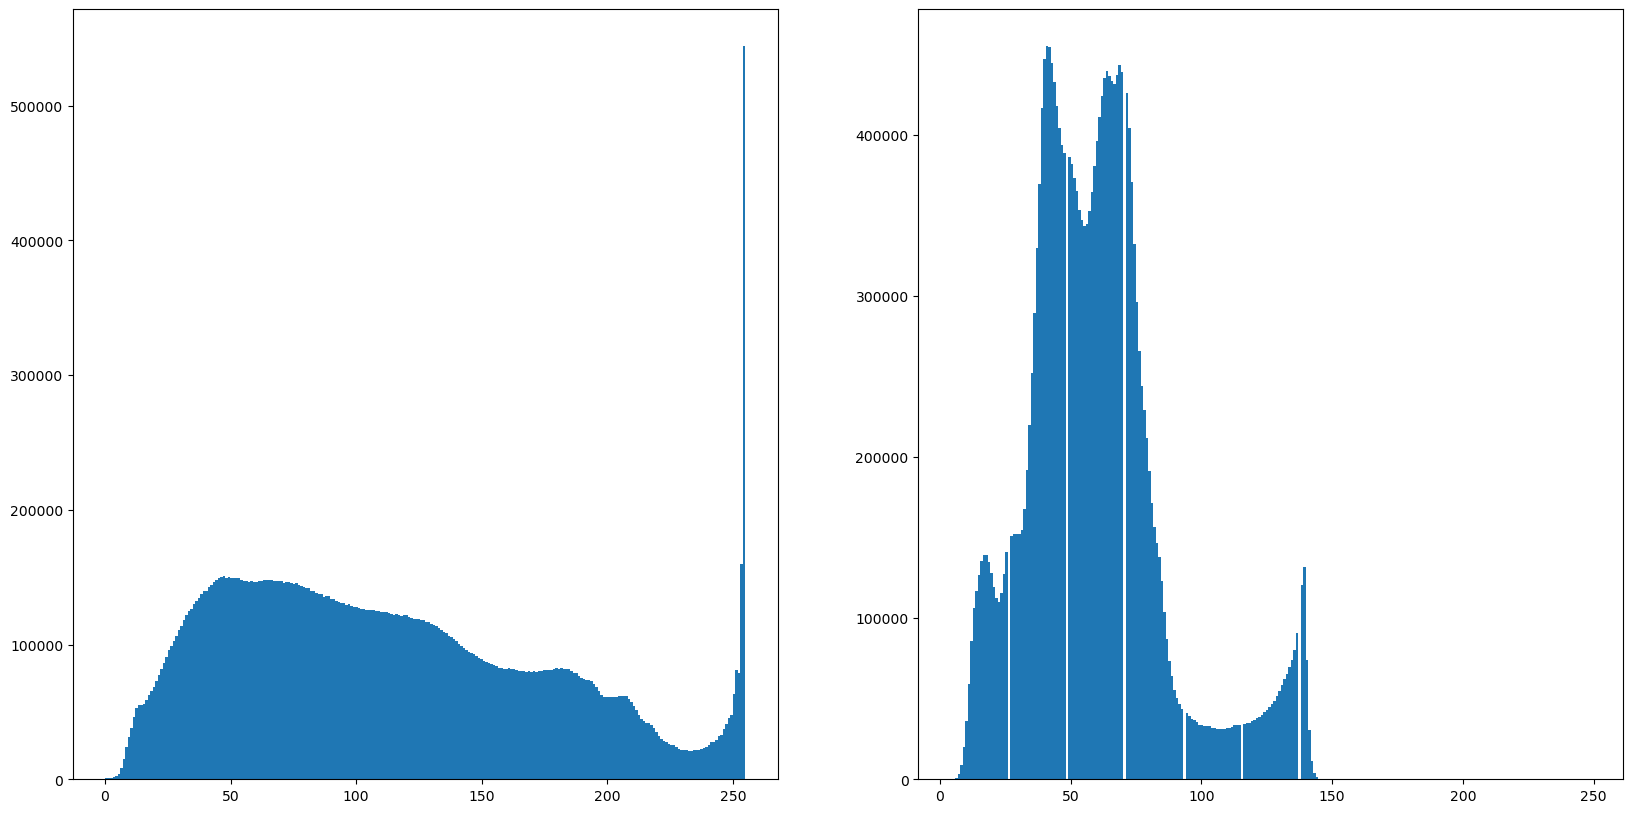

In [5]:
plt.figure(figsize = (20,10))

plt.subplot(1,2,1)
plt.hist(gt[:,:,0].flatten(), bins=256)

plt.subplot(1,2,2)
plt.hist(pred[:,:,0].flatten(), bins=256)

plt.show()

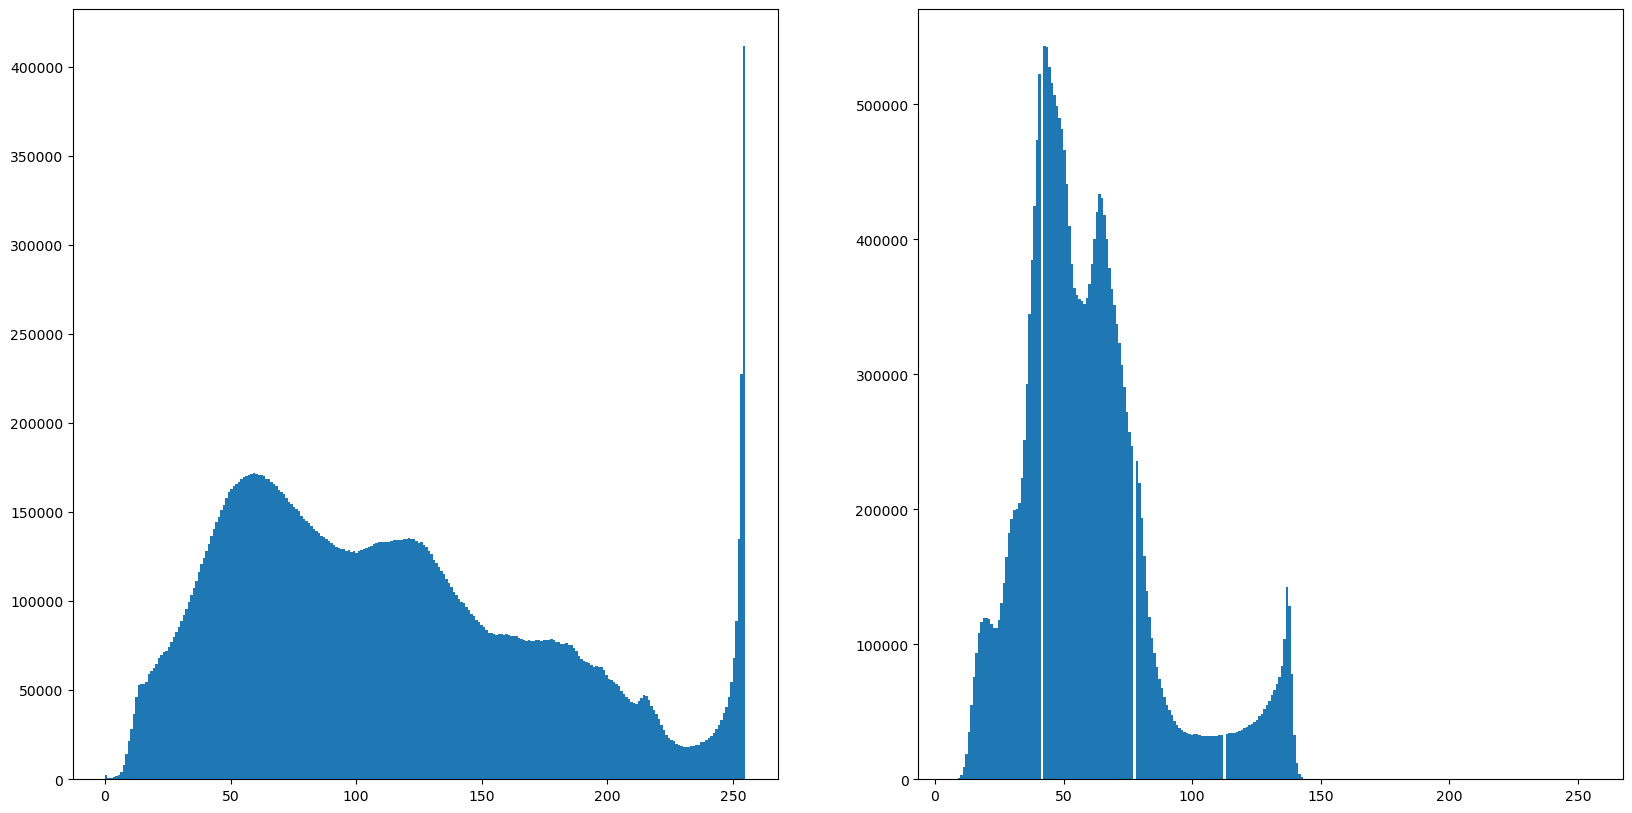

In [6]:
plt.figure(figsize = (20,10))

plt.subplot(1,2,1)
plt.hist(gt[:,:,1].flatten(), bins=256)

plt.subplot(1,2,2)
plt.hist(pred[:,:,1].flatten(), bins=256)

plt.show()

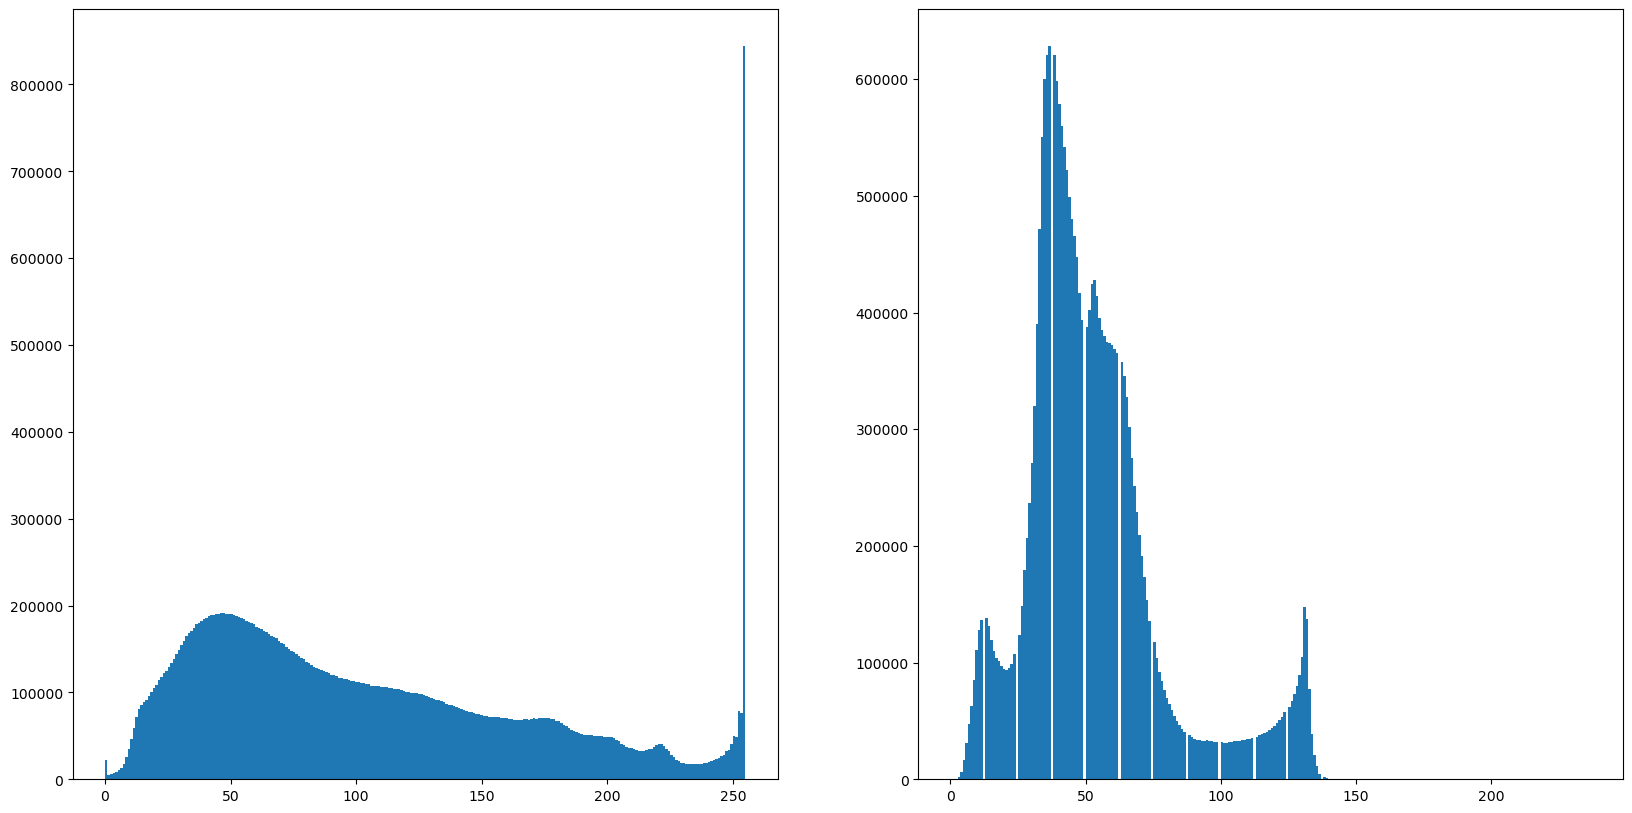

In [7]:
plt.figure(figsize = (20,10))

plt.subplot(1,2,1)
plt.hist(gt[:,:,2].flatten(), bins=256)

plt.subplot(1,2,2)
plt.hist(pred[:,:,2].flatten(), bins=256)

plt.show()
    

In [8]:


def hist_eq(src, template):
    """
    Return modified source array so that the cumulative density function of
    its values matches the cumulative density function of the template.
    """
    dummy = src.copy()

    for c in range(src.shape[2]):
        source = src[:,:,c]
        if source.dtype.kind == 'u':
            src_lookup = source.reshape(-1)
            src_counts = np.bincount(src_lookup)
            
        else:
            src_values, src_lookup, src_counts = np.unique(source.reshape(-1),
                                                        return_inverse=True,
                                                        return_counts=True)
        tmpl_values, tmpl_counts = template[c]

        # calculate normalized quantiles for each array
        src_quantiles = np.cumsum(src_counts) / source.size
        tmpl_quantiles = np.cumsum(tmpl_counts) / np.sum(tmpl_counts)

        interp_a_values = np.interp(src_quantiles, tmpl_quantiles, tmpl_values)
        dummy[:,:,c] = interp_a_values[src_lookup].reshape(source.shape)
    
    return dummy

        
def get_channel_hist(im):

    HIST = []

    for c in range(im.shape[2]):
        hist = np.unique(im[:,:,c], return_counts=True)
        HIST.append(hist)
    
    return HIST

# Getting the mean histogram

In [9]:
PATH  = './Data/clear/'
images = [PATH + im for im in os.listdir(PATH)]


for im in images:
    image = Image.open(im)
    image = np.array(image)

    try:
        temp_hist = get_channel_hist(image)
        for c in range(len(temp_hist)):
            HIST[c][1] += temp_hist[c][1]
    except:
        HIST = get_channel_hist(image)


## taking log

In [37]:
logged_hist = HIST.copy()

for c in range(len(HIST)):
    logged_hist[c] = (HIST[c][0], np.log10(HIST[c][1]+1))

<BarContainer object of 256 artists>

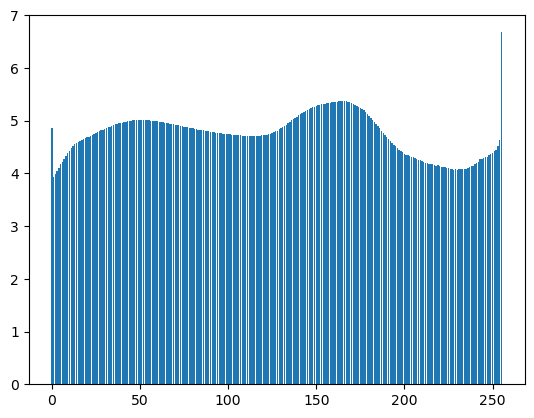

In [38]:
plt.bar(logged_hist[2][0], logged_hist[2][1])

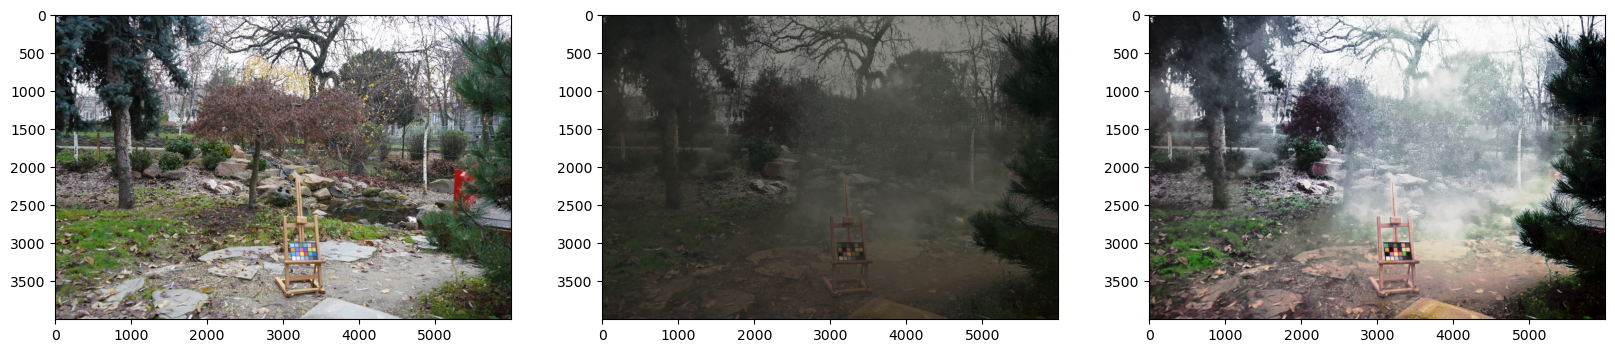

In [39]:
out = hist_eq(pred, logged_hist)
plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
plt.imshow(gt)

plt.subplot(1,3,2)
plt.imshow(pred)

plt.subplot(1,3,3)
plt.imshow(out)

In [56]:
import pickle
with open("./post_proc.ob", "wb") as f:
    pickle.dump(logged_hist, f)

In [65]:
def perform_hist_eq(source, target):
    with open("./post_proc.ob", "rb") as f:
        logged_hist = pickle.load(f)
    paths = [source + path for path in os.listdir(source) if path.endswith(".png")]
    for path in paths:
        image = Image.open(path)
        image = np.array(image)[:,:,:3]
        out = hist_eq(image, logged_hist)

        saving_image = cv2.cvtColor(out, cv2.COLOR_RGB2BGR)

        alpha = np.full((saving_image.shape[0], saving_image.shape[1]), 255, dtype = np.float32)
        saving_image = np.dstack((saving_image, alpha))

        cv2.imwrite(target + path.split("/")[-1], saving_image)

perform_hist_eq("./Submission/finaltest_3/", "./Submission/post_proc_3/")

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# do gamma correction
#img_gamma1 = np.power(img, gamma).clip(0,255).astype(np.uint8)

# gamma correction
def gammaCorrection(src, gamma):
    invGamma = 1 / gamma

    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)

    return cv2.LUT(src, table)


def do_gamma_correction(folder, gamma_B, gamma_G, gamma_R):
    for filename in os.listdir(folder):
        if filename.endswith('png'):
            img = cv2.imread(os.path.join(folder,filename))
            # do gamma correction
            gammaImg_B = gammaCorrection(img[:,:, 0], gamma_B)
            gammaImg_G = gammaCorrection(img[:,:, 1], gamma_G)
            gammaImg_R = gammaCorrection(img[:,:, 2], gamma_R)
            gammaImg = np.dstack((gammaImg_B,gammaImg_G, gammaImg_R))

            # save to gamma folder
            cv2.imwrite(os.path.join(savepath  , filename), gammaImg)


#do_gamma_correction(readpath, gamma_B=1.9, gamma_G=1.6, gamma_R=1.24)
# for 2020 GT images, gamma values should be: R(1.07), G(1.17), B(1.05), please verify the adjusted mean and variance
# for 2021 GT images, gamma values should be: R(0.65), G(0.79), B(0.92), please verify the adjusted mean and variance

In [6]:

do_gamma_correction(input_path, gamma_B=1, gamma_G=0.85, gamma_R=0.72)

In [13]:
import cv2

# Load the original image
original_image = cv2.imread('Submission/data_modified/26.png')

# Load the gamma corrected image
gamma_corrected_image = cv2.imread('Submission/gamma_data_modified/26.png')

# Calculate the PSNR
psnr = cv2.PSNR(original_image, gamma_corrected_image)

print("PSNR:", psnr)


PSNR: 23.86498243691497
